1) Some values turn out to be highly fraudulent. A transparent sample is the merchant-side email domain 'protonmail.com'. Since this an end-to-end encrypted email service, it is no surprise that 95% of transactions to this domain turn fraudulent.

A brief search across our feature space yields 232 columns, or >50% our total features, containing at least one highly fraudulent value. 
![alt text](https://nycdsa-blog-files.s3.us-east-2.amazonaws.com/2019/08/Screenshot-2019-08-27-15.00.29.png)

From this graphic, two prominent feature typologies come to mind. **First, it is eminently sensible for fraudsters to repeat tactics within features known to be "safe" or essential to consumer welfare. We therefore want to identify features with large numbers of fraudulent values that might make up relatively low percentages of all possible values.**

If we restrict ourselves to >500 high-risk values per feature:

![alt text](https://nycdsa-blog-files.s3.us-east-2.amazonaws.com/2019/08/Screenshot-2019-08-22-01.14.57.png)

![alt text](https://nycdsa-blog-files.s3.us-east-2.amazonaws.com/2019/08/Screenshot-2019-08-22-01.23.23.png)

We obtain a list of features that fit that profile. Some have relatively higher levels of risk, but the nearly 9,000 noted values in id_02, for instance, make up fewer than 7% of 115,000 total unique values.

Second, features dominated by their high-risk values should be naturally suspect. Consider features whose unique values are majority high-risk:

![alt text](https://nycdsa-blog-files.s3.us-east-2.amazonaws.com/2019/08/Screenshot-2019-08-28-13.15.59.png)

![alt text](https://nycdsa-blog-files.s3.us-east-2.amazonaws.com/2019/08/Screenshot-2019-08-28-13.16.17.png)


These features all have relatively few uniques — typically fewer than 100.

Altogether we generate a list of features that we suspect to have greater relevance, on which we may perform specific analyses.

2) Null Spaces

The examination of null values is a basic element of any exploratory analysis.

Null values are widespread, particularly as we combine the transaction and identity CSV files. We attribute this to the limitations of Vesta's data collection capabilities.

The distribution of nulls across all 436 features yields a major insight. Reading the graph like a contour plot, our eyes are drawn to the edge of the shape generated by the null values. What is immediately obvious is the incredible uniformity of null spaces across groups of neighboring features.

![alt text](https://nycdsa-blog-files.s3.us-east-2.amazonaws.com/2019/08/Screenshot-2019-08-28-14.31.04.png)

This raises two questions for continuing investigation: to what extent are features within these groups correlated? Are there, perhaps, powerful interactions among in-group variables (or, alternately, out-group variables) that would boost our predictions? 


**New Features**


*   When the card is issued in US but the IP Address is found to be in other     countries(eg:Transaction within foreign countries)
*   High volume of similar transaction over the past days if the card has high risk of fraudulent activity
*     while a billing ZIP code is not always necessary to process a card payment, including it allows it to be verified by the card issuer. If verification fails, you may want to consider rejecting the payment as this may be an indication of fraud.
*   When some transaction on that day has a sudden change in value (increased value)
when compared to the mean of the whole transaction amount in that day(could be added in hour also)
*   D9 is simply D8 minus its integer part. The presence of this feature gives us a clue about what D8 means. My best guess is that D9 indicates the difference between the time of day when the card was issue/activated (?) and when it was used in the transaction. I.e., if the card was activated at 9 AM, and a transaction is then made at 9 PM, you will get D9 = 0.5 since the time of day is shifted by half a day. This feature might be useful to detect fraud committed when the cardholder and fraudster are in very different time-zones.



In [0]:
#Importing my kaggle.json file
#its the unique id that can be got in our kaggle account

from google.colab import files
files.upload()

In [0]:
#making a root kaggle directory
!mkdir -p ~/.kaggle
#moving the kaggle.json to the root kaggle directory
!mv kaggle.json ~/.kaggle
#giving permission to the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
#downloading the data from kaggle command line
!kaggle competitions download -c ieee-fraud-detection

In [0]:
#unzipping all the zip files
!unzip sample_submission.csv.zip
!unzip train_transaction.csv.zip
!unzip train_identity.csv.zip
!unzip test_transaction.csv.zip
!unzip test_identity.csv.zip

#Removing the zip files after unzipping it
!rm *.csv.zip

In [0]:
#importing the required modules
import os
import gc
import pandas as pd
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import datetime
from tqdm import tqdm_notebook
!pip install catboost
import random
from catboost import Pool, CatBoostClassifier,CatBoostRegressor,cv
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import recall_score as rs
from sklearn.metrics import precision_score as ps
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
import warnings
warnings.filterwarnings('ignore')


In [0]:
#helper function to create a correlation plot
def create_corr_plot(features):
  #features:lost of features you want to see in the correlation plot
  corr = train[features].corr()
  return sns.heatmap(corr,annot=True)

In [0]:
#helper function to create a list of column name:
def create_cols(col_base,start,end):
  #col_base:base name of the column
  #start:starting number of column
  #end:ending number of the column
  #eg create_cols('A',1,4) it returns a list of ['A1','A2','A3','A4']
  return [col_base + str(i) for i in range(start,end+1)]

In [0]:
#helper function to seed everything
def seed_everything(seed=0):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)

In [0]:
#To include our drive in working directory
from google.colab import drive
drive.mount('/content/drive')

In [0]:
LOCAL_TEST = True
SEED = 42
seed_everything(SEED)
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [0]:
#Reading the main csv files i used to do in this competition
train = pd.read_csv('train_transaction.csv')
test = pd.read_csv('test_transaction.csv')

In [0]:
#reading the identity file i used in the competition(Didn't used in this competition)
train_id = pd.read_csv('train_identity.csv')
test_id = pd.read_csv('test_identity.csv')

In [0]:
#Merging the column on TransactionID key
train = train.merge(train_id,on='TransactionID',how='left',left_index=True)
test = test.merge(test_id,on='TransactionID',how='left',left_index=True)

In [0]:
#LabelEncoding the categorical values in train and test data
for col in tqdm_notebook(train.columns):
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

In [0]:
#helper function to reduce the memory usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
  
reduce_mem_usage(train)
reduce_mem_usage(test)

# Data Visualization and Meaning

In [0]:
########################### All features columns
#################################################################################
## Main Data
# 'TransactionID',                     -> This is pure noise, we cannot use this column as feature
# 'isFraud',                           -> Our Target
# 'TransactionDT',                     -> Time from reference time point. VERY valuable column
# 'TransactionAmt',                    -> Many unique values and has to be combined with other columns
#                                         The best score boost should come from 
#                                         TransactionDT->TransactionAmt combination
# 'ProductCD',                         -> 100% categorical feature options to use:
#                                         Frequency encoding/Target encoding/
#                                         Combinations with other columns/Model categorical feature
# 'card1' - 'card6',                   -> Categorical features with information about Client
# 'addr1' - 'addr2',                   -> add2 - Country / addr1 - subzone
# 'dist1' - 'dist2',                   -> dist2 - Country distance / dist1 - local distance from merchant
# 'P_emaildomain' - 'R_emaildomain',   -> Categorical feature. It's possible to make 
#                                         subgroup feature from it or general group
# 'C1' - 'C14'                         -> Counts. Should be numerical features (all ints?)
# 'D1' - 'D15'                         
# 'M1' - 'M9'
# 'V1' - 'V339'

## Identity Data
# 'TransactionID'
# 'id_01' - 'id_38'
# 'DeviceType',
# 'DeviceInfo'

#Categorical Features - Transaction
  #ProductCD
  #card1 - card6
  #addr1, addr2
  #P_emaildomain
  #R_emaildomain
  #M1 - M9
#Categorical Features - Identity
  #DeviceType
  #DeviceInfo
  #id_12 - id_38

# Numpy random permutation feature importance

In [0]:
#LightGBM fine tuning parameters used for finding the important feature that is used in the function below 
params = {
    'min_data_in_leaf': 106, 
    'num_leaves': 500, 
    'learning_rate': 0.07,
    'min_child_weight': 0.03454472573214212,
    'bagging_fraction': 0.4181193142567742, 
    'feature_fraction': 0.3797454081646243,
    'reg_lambda': 0.6485237330340494,
    'reg_alpha': 0.3899927210061127,
    'max_depth': -1, 
    'objective': 'binary',
    'seed': 42,
    'tree_learner':'serial',
    'feature_fraction_seed': 42,
    'n_jobs':-1,
    'bagging_seed': 42,
    'drop_seed': 42,
    'data_random_seed': 42,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric':'auc',
    'od_wait':500,
}

In [0]:
#Helper function to get the feature importance using numpy random.permutation method tested with LightGBM model
def permutation_importance(x,y,model):
  #x:train data with the feature excluding the target value
  #y:train data with the target value in it
  #model:The algorithm(model) which is used for getting the important values
  #It outputs the column name with their corresponding importance value
  #When the value outputs a negative value it means it is helping the model to get the target value almost correct
  #When the value outputs a positive number it means that feature is hurting the model
  perm={}
  print(';')
  y_true = model.predict_proba(x)[:,1]
  print(';')
  baseline = roc_auc_score(y,y_true)
  print(';')
  for cols in x.columns:
    print(cols)
    value = x[cols]
    x[cols] = np.random.permutation(x[cols].values)
    y_true = model.predict_proba(x)[:,1]
    perm[cols] = roc_auc_score(y,y_true) - baseline
    x[cols] = value
  return perm
permutation_importance(x,y,model)

In [0]:
#This was the output of the permutation_importance method
#Since it took lot of time to get the output,I saved the dictionary value instead of compiling everytime
feature_importance = {
                   'C1': 0.001066900288706596,
                   'C10': 0.0007553914798517081,
                   'C11': 0.0007793395203035125,
                   'C12': 0.0007016863662808737,
                   'C13': 0.0009399406520532727,
                   'C14': 0.0010407009386579347,
                   'C2': 0.001066900288706596,
                   'C3': 0.001066900288706596,
                   'C4': 0.001112079427025181,
                   'C5': 0.001112079427025181,
                   'C6': 0.0011410526605524218,
                   'C7': 0.0008623105121724484,
                   'C8': 0.0007957440176067365,
                   'C9': 0.0007957440176067365,
                   'D1': 0.0010407009386579347,
                   'D10': 0.0010160809447099517,
                   'D11': 0.0010160809447099517,
                   'D12': 0.0010160809447099517,
                   'D13': 0.0010160809447099517,
                   'D14': 0.0010160809447099517,
                   'D15': 0.0009503030029646142,
                   'D2': 0.0009337723524962538,
                   'D3': 0.0009337723524962538,
                   'D4': 0.0009337723524962538,
                   'D5': 0.0009337723524962538,
                   'D6': 0.0009337723524962538,
                   'D7': 0.0009337723524962538,
                   'D8': 0.0009337723524962538,
                   'D9': 0.0009337723524962538,
                   'M1': 0.0009503030029646142,
                   'M2': 0.0009503030029646142,
                   'M3': 0.0009503030029646142,
                   'M4': 0.0002661462367857803,
                   'M5': 0.00026085077615878305,
                   'M6': 0.00026085077615878305,
                   'M7': 0.00026085077615878305,
                   'M8': 0.00026085077615878305,
                   'M9': 0.00026085077615878305,
                   'DeviceInfo': -0.2532969045012518,
                   'DeviceType': -0.2532969045012518,
                   'P_emaildomain': -0.00019475972319193957,
                   'ProductCD': -0.00011856643856278382,
                   'R_emaildomain': -0.0001665640874137786,
                   'TransactionAmt': -0.00011856643856278382,
                   'TransactionDT': -7.590858016204294e-05,
                   'TransactionID': -0.00019929295713894124,
                   'V1': 0.00026085077615878305,
                   'V10': 0.00023666707429126355,
                   'V100': -0.0037496496337871,
                   'V101': -0.003994464563527589,
                   'V102': -0.005020330849603294,
                   'V103': -0.008190691688446439,
                   'V104': -0.008190691688446439,
                   'V105': -0.008190691688446439,
                   'V106': -0.008190691688446439,
                   'V107': -0.008190691688446439,
                   'V108': -0.008198853471273138,
                   'V109': -0.008227658896887702,
                   'V11': 0.00023666707429126355,
                   'V110': -0.008227658896887702,
                   'V111': -0.008227658896887702,
                   'V112': -0.008227658896887702,
                   'V113': -0.008227658896887702,
                   'V114': -0.008227658896887702,
                   'V115': -0.008227658896887702,
                   'V116': -0.008227658896887702,
                   'V117': -0.008227658896887702,
                   'V118': -0.008227658896887702,
                   'V119': -0.008227658896887702,
                   'V12': 0.00025171407691693126,
                   'V120': -0.008227658896887702,
                   'V121': -0.008227658896887702,
                   'V122': -0.008227658896887702,
                   'V123': -0.008227658896887702,
                   'V124': -0.008321890428123258,
                   'V125': -0.00840399826228766,
                   'V126': -0.010339988893482088,
                   'V127': -0.010339988893482088,
                   'V128': -0.010339988893482088,
                   'V129': -0.011091891225612382,
                   'V13': 0.00025171407691693126,
                   'V130': -0.011091891225612382,
                   'V131': -0.011091891225612382,
                   'V132': -0.011919156464958114,
                   'V133': -0.013368841973401713,
                   'V134': -0.013368841973401713,
                   'V135': -0.013368841973401713,
                   'V136': -0.013368841973401713,
                   'V137': -0.013368841973401713,
                   'V138': -0.013368841973401713,
                   'V139': -0.013368971141334507,
                   'V14': 0.00025171407691693126,
                   'V140': -0.01336916527538734,
                   'V141': -0.01336916527538734,
                   'V142': -0.01336916527538734,
                   'V143': -0.0135494691027227,
                   'V144': -0.013761386293287381,
                   'V145': -0.013763369161177819,
                   'V146': -0.013928220520867951,
                   'V147': -0.013928220520867951,
                   'V148': -0.013942034186289809,
                   'V149': -0.014512189933682085,
                   'V15': 0.00029642223209602747,
                   'V150': -0.014512189933682085,
                   'V151': -0.014512189933682085,
                   'V152': -0.014512189933682085,
                   'V153': -0.014800330641475568,
                   'V154': -0.015154447034296137,
                   'V155': -0.015211558538092973,
                   'V156': -0.018284838168415418,
                   'V157': -0.018284838168415418,
                   'V158': -0.018284838168415418,
                   'V159': -0.018284838168415418,
                   'V16': 0.0002787393034584529,
                   'V160': -0.018284838168415418,
                   'V161': -0.018392063433191996,
                   'V162': -0.018392063433191996,
                   'V163': -0.018392063433191996,
                   'V164': -0.018392063433191996,
                   'V165': -0.01861590670493063,
                   'V166': -0.01861590670493063,
                   'V167': -0.01861590670493063,
                   'V168': -0.01861590670493063,
                   'V169': -0.01861590670493063,
                   'V17': 0.00029451091186072365,
                   'V170': -0.01861590670493063,
                   'V171': -0.01861590670493063,
                   'V172': -0.01861590670493063,
                   'V173': -0.01863775791078226,
                   'V174': -0.01863775791078226,
                   'V175': -0.018686624831795617,
                   'V176': -0.018686624831795617,
                   'V177': -0.018686624831795617,
                   'V178': -0.018686624831795617,
                   'V179': -0.018686624831795617,
                   'V18': 0.0002889718919760753,
                   'V180': -0.018686624831795617,
                   'V181': -0.019290020643108585,
                   'V182': -0.019290020643108585,
                   'V183': -0.019288465957148948,
                   'V184': -0.019288054844747604,
                   'V185': -0.019288054844747604,
                   'V186': -0.019288054844747604,
                   'V187': -0.0218468535036076,
                   'V188': -0.02298320155553324,
                   'V189': -0.02769123122192485,
                   'V19': 0.00028868663550907225,
                   'V190': -0.028316203173386345,
                   'V191': -0.028316203173386345,
                   'V192': -0.028316203173386345,
                   'V193': -0.028316203173386345,
                   'V194': -0.028553167987830252,
                   'V195': -0.028553167987830252,
                   'V196': -0.028553167987830252,
                   'V197': -0.028666909057213696,
                   'V198': -0.029175994613639844,
                   'V199': -0.029792298301307696,
                   'V2': 0.00026085077615878305,
                   'V20': 0.0002923585800584938,
                   'V200': -0.03136280661083157,
                   'V201': -0.037500518250237924,
                   'V202': -0.037500518250237924,
                   'V203': -0.037500518250237924,
                   'V204': -0.03780188079483826,
                   'V205': -0.03793784775049325,
                   'V206': -0.03794976007413586,
                   'V207': -0.03815051319789908,
                   'V208': -0.03815051319789908,
                   'V209': -0.03866003024825426,
                   'V21': 0.0002923585800584938,
                   'V210': -0.03947804702964697,
                   'V211': -0.03947804702964697,
                   'V212': -0.04096938473793843,
                   'V213': -0.04187301888274475,
                   'V214': -0.04187301888274475,
                   'V215': -0.04187301888274475,
                   'V216': -0.04187301888274475,
                   'V217': -0.04187301888274475,
                   'V218': -0.04187301888274475,
                   'V219': -0.04187301888274475,
                   'V22': 0.00026167979480395953,
                   'V220': -0.041871602621328496,
                   'V221': -0.041871602621328496,
                   'V222': -0.041871602621328496,
                   'V223': -0.04197879799319748,
                   'V224': -0.0420895315133778,
                   'V225': -0.04209984431169955,
                   'V226': -0.04209984431169955,
                   'V227': -0.04209984431169955,
                   'V228': -0.04210123917251174,
                   'V229': -0.043294631978730624,
                   'V23': 0.0003245828371234438,
                   'V230': -0.043294631978730624,
                   'V231': -0.043294631978730624,
                   'V232': -0.043294631978730624,
                   'V233': -0.043294631978730624,
                   'V234': -0.043294631978730624,
                   'V235': -0.043294631978730624,
                   'V236': -0.043278667552582695,
                   'V237': -0.043278667552582695,
                   'V238': -0.043278667552582695,
                   'V239': -0.04355400967996437,
                   'V24': 0.0003245828371234438,
                   'V240': -0.04355400967996437,
                   'V241': -0.04355400967996437,
                   'V242': -0.04516707589347935,
                   'V243': -0.045996859270590607,
                   'V244': -0.048509867939757756,
                   'V245': -0.04974137318397531,
                   'V246': -0.05452848275380062,
                   'V247': -0.05586042956848114,
                   'V248': -0.05637939931668301,
                   'V249': -0.05637939931668301,
                   'V25': 0.0003245828371234438,
                   'V250': -0.056388432239979025,
                   'V251': -0.05737894281708211,
                   'V252': -0.057765563755436844,
                   'V253': -0.05880372056988137,
                   'V254': -0.05880372056988137,
                   'V255': -0.05932597463144984,
                   'V256': -0.05932597463144984,
                   'V257': -0.06351160612188644,
                   'V258': -0.12108609942297943,
                   'V259': -0.12108609942297943,
                   'V26': 0.00027932319176982023,
                   'V260': -0.12108609942297943,
                   'V261': -0.12170687914893163,
                   'V262': -0.12406229342878339,
                   'V263': -0.1291528835236444,
                   'V264': -0.1291528835236444,
                   'V265': -0.13258114958325729,
                   'V266': -0.13309821569675828,
                   'V267': -0.13428590897856063,
                   'V268': -0.13571512047797418,
                   'V269': -0.13571512047797418,
                   'V27': 0.00027932319176982023,
                   'V270': -0.13571512047797418,
                   'V271': -0.13571512047797418,
                   'V272': -0.13571512047797418,
                   'V273': -0.13571512047797418,
                   'V274': -0.13571512047797418,
                   'V275': -0.13940367461373127,
                   'V276': -0.13940367461373127,
                   'V277': -0.13940367461373127,
                   'V278': -0.13940367461373127,
                   'V279': -0.1393967504991832,
                   'V28': 0.00023547840660265162,
                   'V280': -0.1393967504991832,
                   'V281': -0.14205352375686786,
                   'V282': -0.14205352375686786,
                   'V283': -0.14427058771615164,
                   'V284': -0.14427058771615164,
                   'V285': -0.14427058771615164,
                   'V286': -0.14427058771615164,
                   'V287': -0.14427058771615164,
                   'V288': -0.14427058771615164,
                   'V289': -0.14427058771615164,
                   'V29': 0.00024792842042675733,
                   'V290': -0.14427058771615164,
                   'V291': -0.14427058771615164,
                   'V292': -0.14555934458717001,
                   'V293': -0.14554881820742105,
                   'V294': -0.15596565446273014,
                   'V295': -0.1669023370417847,
                   'V296': -0.1669023370417847,
                   'V297': -0.1669023370417847,
                   'V298': -0.1669023370417847,
                   'V299': -0.1669023370417847,
                   'V3': 0.00026085077615878305,
                   'V30': 0.00023270639143080363,
                   'V300': -0.1669023370417847,
                   'V301': -0.1669023370417847,
                   'V302': -0.1669023370417847,
                   'V303': -0.16896050627027637,
                   'V304': -0.16896050627027637,
                   'V305': -0.16896050627027637,
                   'V306': -0.16896050627027637,
                   'V307': -0.17112367662931827,
                   'V308': -0.17732981644601287,
                   'V309': -0.17732981644601287,
                   'V31': 0.0002504447323471437,
                   'V310': -0.17700053910610325,
                   'V311': -0.17700053910610325,
                   'V312': -0.17826378136148568,
                   'V313': -0.17826378136148568,
                   'V314': -0.17947861324207848,
                   'V315': -0.18214825182967864,
                   'V316': -0.1846691707396495,
                   'V317': -0.20392975421470327,
                   'V318': -0.21146399880069455,
                   'V319': -0.21146399880069455,
                   'V32': 0.0002534389486340549,
                   'V320': -0.21146399880069455,
                   'V321': -0.21146399880069455,
                   'V322': -0.21138599937300595,
                   'V323': -0.21138599937300595,
                   'V324': -0.21138599937300595,
                   'V325': -0.21138599937300595,
                   'V326': -0.21134904520025022,
                   'V327': -0.21134904520025022,
                   'V328': -0.21134904520025022,
                   'V329': -0.21134904520025022,
                   'V33': 0.0002534389486340549,
                   'V330': -0.2113741898062329,
                   'V331': -0.2113741898062329,
                   'V332': -0.2113741898062329,
                   'V333': -0.2119889687008487,
                   'V334': -0.2120943813684153,
                   'V335': -0.2120943813684153,
                   'V336': -0.2120943813684153,
                   'V337': -0.2120943813684153,
                   'V338': -0.2120943813684153,
                   'V339': -0.21259379860741479,
                   'V34': 0.00018729180400400836,
                   'V35': 0.00018729180400400836,
                   'V36': 0.00018729180400400836,
                   'V37': 0.00018729180400400836,
                   'V38': 0.00018729180400400836,
                   'V39': 0.0002453782242163305,
                   'V4': 0.00025858634595343766,
                   'V40': 0.000247928887503468,
                   'V41': 0.000247928887503468,
                   'V42': 0.00028580778716214006,
                   'V43': 0.00028580778716214006,
                   'V44': 0.0002643075682048357,
                   'V45': 0.00034196577514800097,
                   'V46': 0.00034196577514800097,
                   'V47': 0.00034196577514800097,
                   'V48': 0.00034196577514800097,
                   'V49': 0.00034196577514800097,
                   'V5': 0.00025858634595343766,
                   'V50': 0.0004130114926115258,
                   'V51': 0.00048222002764741756,
                   'V52': 0.0004948227755458001,
                   'V53': 0.0004951014080162297,
                   'V54': 0.0005045615790897351,
                   'V55': 0.0005422638813019631,
                   'V56': 0.0005422638813019631,
                   'V57': 0.0005463842619255477,
                   'V58': 0.0005463842619255477,
                   'V59': 0.0005463842619255477,
                   'V6': 0.00025858634595343766,
                   'V60': 0.0005463842619255477,
                   'V61': 0.0005463842619255477,
                   'V62': 0.0004971193915805916,
                   'V63': 0.0004528505432497276,
                   'V64': 0.0004528505432497276,
                   'V65': 0.0004528505432497276,
                   'V66': 0.0004528505432497276,
                   'V67': 0.00046490235297347304,
                   'V68': 0.00046490235297347304,
                   'V69': 0.00046490235297347304,
                   'V7': 0.00025858634595343766,
                   'V70': 0.00046490235297347304,
                   'V71': -0.0001642458584670825,
                   'V72': -0.0002485159179670404,
                   'V73': -0.0002712256107560984,
                   'V74': -0.00039850235001359646,
                   'V75': -0.0008909121225085803,
                   'V76': -0.0009492107229180924,
                   'V77': -0.0009492107229180924,
                   'V78': -0.0009492107229180924,
                   'V79': -0.0007312270979741298,
                   'V8': 0.00023666707429126355,
                   'V80': -0.0007312488382705817,
                   'V81': -0.0007312488382705817,
                   'V82': -0.0007968557450278579,
                   'V83': -0.0010416215043326238,
                   'V84': -0.0010416215043326238,
                   'V85': -0.0010416215043326238,
                   'V86': -0.0014698135835002901,
                   'V87': -0.0035380673372019666,
                   'V88': -0.0035380673372019666,
                   'V89': -0.0035380673372019666,
                   'V9': 0.00023666707429126355,
                   'V90': -0.0037715692026798475,
                   'V91': -0.0037715692026798475,
                   'V92': -0.0037715692026798475,
                   'V93': -0.0037715692026798475,
                   'V94': -0.0037715692026798475,
                   'V95': -0.0037715692026798475,
                   'V96': -0.003750719154460791,
                   'V97': -0.0037496496337871,
                   'V98': -0.0037496496337871,
                   'V99': -0.0037496496337871,
                   'addr1': -0.0003275469906567352,
                   'addr2': -0.00019475972319193957,
                   'card1': -0.00011856643856278382,
                   'card2': -0.00011856643856278382,
                   'card3': -0.00019837820869228473,
                   'card4': -0.00022600129338401498,
                   'card5': -0.00022600129338401498,
                   'card6': -0.0004337944940964178,
                   'dist1': -0.00019475972319193957,
                   'dist2': -0.00019475972319193957,
                   'id_01': -0.21259379860741479,
                   'id_02': -0.21259379860741479,
                   'id_03': -0.21259379860741479,
                   'id_04': -0.21259379860741479,
                   'id_05': -0.21259379860741479,
                   'id_06': -0.22838626911683724,
                   'id_07': -0.22838626911683724,
                   'id_08': -0.22838626911683724,
                   'id_09': -0.22857210202806244,
                   'id_10': -0.22857210202806244,
                   'id_11': -0.22976963491704838,
                   'id_12': -0.21791842672932082,
                   'id_13': -0.23830902945221144,
                   'id_14': -0.23830902945221144,
                   'id_15': -0.23830902945221144,
                   'id_16': -0.23830902945221144,
                   'id_17': -0.24658460820845185,
                   'id_18': -0.24658460820845185,
                   'id_19': -0.24658460820845185,
                   'id_20': -0.24720220637790735,
                   'id_21': -0.24738610414798645,
                   'id_22': -0.24738610414798645,
                   'id_23': -0.24738610414798645,
                   'id_24': -0.247408425487747,
                   'id_25': -0.247408425487747,
                   'id_26': -0.247408425487747,
                   'id_27': -0.247408425487747,
                   'id_28': -0.247408425487747,
                   'id_29': -0.247408425487747,
                   'id_30': -0.247408425487747,
                   'id_31': -0.247408425487747,
                   'id_32': -0.247408425487747,
                   'id_33': -0.24767193418498334,
                   'id_34': -0.24781791178280987,
                   'id_35': -0.2532969045012518,
                   'id_36': -0.2532969045012518,
                   'id_37': -0.2532969045012518,
                   'id_38': -0.2532969045012518,
                   'isFraud':-1}

In [0]:
#this features has positive values but i didnt exclude this features since i need to use this features 
fi_cmd = {
          'C1': 0.001066900288706596,
           'C10': 0.0007553914798517081,
           'C11': 0.0007793395203035125,
           'C12': 0.0007016863662808737,
           'C13': 0.0009399406520532727,
           'C14': 0.0010407009386579347,
           'C2': 0.001066900288706596,
           'C3': 0.001066900288706596,
           'C4': 0.001112079427025181,
           'C5': 0.001112079427025181,
           'C6': 0.0011410526605524218,
           'C7': 0.0008623105121724484,
           'C8': 0.0007957440176067365,
           'C9': 0.0007957440176067365,
           'D1': 0.0010407009386579347,
           'D10': 0.0010160809447099517,
           'D11': 0.0010160809447099517,
           'D12': 0.0010160809447099517,
           'D13': 0.0010160809447099517,
           'D14': 0.0010160809447099517,
           'D15': 0.0009503030029646142,
           'D2': 0.0009337723524962538,
           'D3': 0.0009337723524962538,
           'D4': 0.0009337723524962538,
           'D5': 0.0009337723524962538,
           'D6': 0.0009337723524962538,
           'D7': 0.0009337723524962538,
           'D8': 0.0009337723524962538,
           'D9': 0.0009337723524962538,
           'M1': 0.0009503030029646142,
           'M2': 0.0009503030029646142,
           'M3': 0.0009503030029646142,
           'M4': 0.0002661462367857803,
           'M5': 0.00026085077615878305,
           'M6': 0.00026085077615878305,
           'M7': 0.00026085077615878305,
           'M8': 0.00026085077615878305,
           'M9': 0.00026085077615878305,
}

In [0]:
#Extracting the values having negative values
feature_imp_greater = [k for k,v in feature_importance.items() if v<0]
feature_imp_greater

In [0]:

f = [i for i in train.columns if i in feature_imp_greater]
train = train[f]
f.remove('isFraud')
test = test[f]

# Feature Engineering


In [0]:
m = create_cols('M',1,9)
for c in m:
  train[c].fillna(-999,inplace=True)
  test[c].fillna(-999,inplace=True)

In [0]:
#Helper function to get the frequency of occurence of that value in the data
def create_freq(cols,train_df,test_df):
  #cols:The columns you want to make the frequency of occurences
  #train_df:train data
  #test_df:test data
  for c in cols:
    freq_train = dict(train[c].value_counts()/train.shape[0])
    freq_test = dict(test[c].value_counts()/test.shape[0])
    train[c+'_freq'] = train[c].map(freq_train)
    test[c+'_freq'] = test[c].map(freq_test)
  return train_df,test_df

In [0]:
#Helper function to calculate the smooth mean
def calc_smooth_mean(df, by, on, m):
    #df:dataFrame
    #by:on which column you want to calculate the smooth mean
    #on:based on which feature that we want to calculate
    #m:optimization value
    mean = df[on].mean()
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    smooth = (counts * means + m * mean) / (counts + m)
    return df[by].map(smooth)
  
#df['x_0'] = calc_smooth_mean(df, by='x_0', on='y', m=10)

In [0]:
train.groupby('Transaction_hour')['isFraud'].value_counts()

In [0]:
#Frequency of fraud that happening per hour 
#This was calculated by taking the number of fraud happening per hour hour by number of transaction happened at that hour
period = {
         0.0: 30,
         1.0: 30,
         2.0: 25,
         3.0: 25,
         4.0: 18,
         5.0: 13,
         6.0: 11,
         7.0: 8,
         8.0: 9,
         9.0: 10,
         10.0: 17,
         11.0: 24,
         12.0: 31,
         13.0: 42,
         14.0: 40,
         15.0: 38,
         16.0: 32,
         17.0: 30,
         18.0: 27,
         19.0: 27,
         20.0: 28,
         21.0: 28,
         22.0: 29,
         23.0: 26
}
#creating a column that puts value 1 when the index value reaches the corresponding number of frequency that happened at that hour
p = np.zeros(train.shape[0])
for k,v in period.items():
  for i in range(v):
    if(i%v==0):
      p[i] = 1
train['priods_in_fraud'] = p

p = np.zeros(test.shape[0])
for k,v in period.items():
  for i in range(v):
    if(i%v==0):
      p[i] = 1
test['priods_in_fraud'] = p

In [0]:
#using the smooth mean function to calucate the smooth mean of all the columns
c = list(train.columns)
q = [cols for cols in c if train[cols].nunique()<50]
q.remove('isFraud')
for c in tqdm_notebook(q):
  train[c] = calc_smooth_mean(train,c,'isFraud',m=300)
for c in tqdm_notebook(q):
  freq = train[c].value_counts()
  test[c] = test[c].map(freq)

In [0]:
#The value "W" has more number of fraud so i created a feature that whenever the value "W" occurs in ProductCD column i insert a value of 1 in the column
train['ProductCD_W'] = np.where(train['ProductCD'] == 'W',1,0)
test['ProductCD_W'] = np.where(test['ProductCD'] == 'W',1,0)

In [0]:
#Extracting the decimal part of the transactionAmt column
#because the decimal part increases the AUC_ROC_SCORE  
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

In [0]:
#The median transaction amount value for corresponding product 
product_median_train = dict(np.ceil(train.groupby('ProductCD')['TransactionAmt'].median()))
train['ProductCD_price_median'] = train['ProductCD'].map(product_median_train)

product_median_test = dict(np.ceil(test.groupby('ProductCD')['TransactionAmt'].median()))
test['ProductCD_price_median'] = test['ProductCD'].map(product_median_test)

#Created a feature that if the transaction amount becomes ore than the median of its corresponding product median value
train['if_greater_than_product_price_median'] = np.where(train['TransactionAmt']>train['ProductCD_price_median'],1,0)
test['if_greater_than_product_price_median'] = np.where(test['TransactionAmt']>test['ProductCD_price_median'],1,0)

In [0]:
#The mean transaction amount value for corresponding product 
product_mean_train = dict(np.ceil(train.groupby('ProductCD')['TransactionAmt'].mean()))
train['ProductCD_price_mean'] = train['ProductCD'].map(product_mean_train)
product_mean_test = dict(np.ceil(test.groupby('ProductCD')['TransactionAmt'].mean()))
test['ProductCD_price_mean'] = test['ProductCD'].map(product_mean_test)

#Created a feature that if the transaction amount becomes ore than the median of its corresponding product median value
train['if_greater_than_product_price_mean'] = np.where(train['TransactionAmt']>train['ProductCD_price_mean'],1,0)
test['if_greater_than_product_price_mean'] = np.where(test['TransactionAmt']>test['ProductCD_price_mean'],1,0)

In [0]:
#Dictionary for the frequency of product appearing in the data
product_value_counts_train = dict(train['ProductCD'].value_counts()/train.shape[0])
product_value_counts_test = dict(test['ProductCD'].value_counts()/test.shape[0])

train['ProductCD_freq'] = train['ProductCD'].map(product_value_counts_train)
test['ProductCD_freq'] = test['ProductCD'].map(product_value_counts_test)

In [0]:
#Dictionary for the frequency of product appearing in the data
create_freq('ProductCD',train,test)
create_freq(create_cols('addr',1,2),train,test)
create_freq(create_cols('dist',1,2),train,test)
create_freq(create_cols('C',1,14),train,test)
create_freq(create_cols('D',1,15),train,test)
create_freq(create_cols('M',1,9),train,test)

In [0]:
print(train.shape)
print(test.shape)

In [0]:
#starting date vslue in this data
startdate = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [0]:
#Extrancting the day feature
train['Transaction_day'] = np.floor((train['TransactionDT'].astype(int) / (3600 * 24) - 1) % 7)
test['Transaction_day'] = np.floor((test['TransactionDT'].astype(int) / (3600 * 24) - 1) % 7)

In [0]:
#Extracting the hour feature
train['Transaction_hour'] = np.floor(train['TransactionDT'].astype(int)/3600)%24
test['Transaction_hour'] = np.floor(test['TransactionDT'].astype(int)/3600)%24

In [0]:
#Extracting the month
train['month'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
train['month'] = (train['month'].dt.year-2017)*12 + train['month'].dt.month 

test['month'] = test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds =x)))
test['month'] = (test['month'].dt.year-2017)*12 + test['month'].dt.month

In [0]:
#Extracting the number of days from the starting date of the data
train['DaysFromStart'] = np.round(train['TransactionDT']/(60*60*24),0)
test['DaysFromStart'] = np.round(test['TransactionDT']/(60*60*24),0)

In [0]:
train['DaysFromPreviousTransaction'] = train['DaysFromStart'].diff()
test['DaysFromPreviousTransaction'] = test['DaysFromStart'].diff()

In [0]:
#Number of transaction per hour
train['TransactionPerHour'] = train.groupby('Transaction_hour')['TransactionAmt'].count()
test['TransactionPerHour'] = test.groupby('Transaction_hour')['TransactionAmt'].count()

In [0]:
#Filling the card values
i_cols = ['TransactionID','card1','card2','card3','card4','card5','card6']

full_df = pd.concat([train[i_cols], test[i_cols]])

full_df['card6'] = np.where(full_df['card6']==30, np.nan, full_df['card6'])
full_df['card6'] = np.where(full_df['card6']==16, np.nan, full_df['card6'])

i_cols = ['card2','card3','card4','card5','card6']

for col in i_cols:
    temp_df = full_df.groupby(['card1',col])[col].agg(['count']).reset_index()
    temp_df = temp_df.sort_values(by=['card1','count'], ascending=False).reset_index(drop=True)
    del temp_df['count']
    temp_df = temp_df.drop_duplicates(keep='first').reset_index(drop=True)
    temp_df.index = temp_df['card1'].values
    temp_df = temp_df[col].to_dict()
    full_df[col] = np.where(full_df[col].isna(), full_df['card1'].map(temp_df), full_df[col])
    
    
i_cols = ['card1','card2','card3','card4','card5','card6']
for col in i_cols:
    train[col] = full_df[full_df['TransactionID'].isin(train['TransactionID'])][col].values
    test[col] = full_df[full_df['TransactionID'].isin(test['TransactionID'])][col].values

In [0]:
#Aggregating the card1 and card2 columns to get the unique id of the user
#card1:value related to the card
#card2:The bank
train['uid'] = train['card1'].astype(str) + train['card2'].astype(str)
test['uid'] = test['card1'].astype(str) + test['card2'].astype(str)

train['uid'] = le.fit_transform(train['uid'])
test['uid'] = le.fit_transform(test['uid'])

In [0]:
#Extracing the weekends
train['sundays'] = np.where(train['Transaction_day']==0.0,1,0)
train['saturdays'] = np.where(train['Transaction_day']==6.0,1,0)
train['weekends'] = train['sundays'].astype(str) + '_' + train['saturdays'].astype(str)
train['weekends'] = le.fit_transform(train['weekends'])

test['sundays'] = np.where(test['Transaction_day']==0.0,1,0)
test['saturdays'] = np.where(test['Transaction_day']==6.0,1,0)
test['weekends'] = test['sundays'].astype(str) + '_' + test['saturdays'].astype(str)
test['weekends'] = le.fit_transform(test['weekends'])

del train['sundays'],train['saturdays'],test['sundays'],test['saturdays']


In [0]:
#Extracting the Recipent email for the card1
train['card1_R_mail'] =np.zeros(train.shape[0])
train['card1_R_mail'] = train['card1'].astype(str) + '_' + train['R_emaildomain'].astype(str)
le.fit(list(train['card1_R_mail'].astype(str).values))
train['card1_R_mail'] = le.transform(list(train['card1_R_mail'].astype(str).values))
train['card1_R_mail'] = train['card1_R_mail'].astype('object')

test['card1_R_mail'] =np.zeros(test.shape[0])
test['card1_R_mail'] = test['card1'].astype(str) + '_' + test['R_emaildomain'].astype(str)
le.fit(list(test['card1_R_mail'].astype(str).values))
test['card1_R_mail'] = le.transform(list(test['card1_R_mail'].astype(str).values))
test['card1_R_mail'] = test['card1_R_mail'].astype('object')

In [0]:
#Extracting the recipent email of card2
train['card2_R_mail'] =np.zeros(train.shape[0])
train['card2_R_mail'] = train['card2'].astype(str) + '_' + train['R_emaildomain'].astype(str)
le.fit(list(train['card2_R_mail'].astype(str).values))
train['card2_R_mail'] = le.transform(list(train['card2_R_mail'].astype(str).values))
train['card2_R_mail'] = train['card2_R_mail'].astype('object')

test['card2_R_mail'] =np.zeros(test.shape[0])
test['card2_R_mail'] = test['card2'].astype(str) + '_' + test['R_emaildomain'].astype(str)
le.fit(list(test['card2_R_mail'].astype(str).values))
test['card2_R_mail'] = le.transform(list(test['card2_R_mail'].astype(str).values))
test['card2_R_mail'] = test['card2_R_mail'].astype('object')

In [0]:
train['TransactionAmt'] = train['TransactionAmt'].astype(str)
test['TransactionAmt'] = test['TransactionAmt'].astype(str)

train['dollars'] = train['TransactionAmt'].map(lambda x:x.split('.')[0])
test['dollars'] = test['TransactionAmt'].map(lambda x:x.split('.')[0])

train['cents'] = train['TransactionAmt'].map(lambda x:x.split('.')[1])
test['cents'] = test['TransactionAmt'].map(lambda x:x.split('.')[1])


In [0]:
#Aggregating the C columns
C = create_cols('C',1,14)

train['sum_c'] = np.zeros(train.shape[0])
train['sum_c'] = train[C].sum(axis=1)

test['sum_c'] = np.zeros(test.shape[0])
test['sum_c'] = test[C].sum(axis=1)

In [0]:
#Then filling the nan values
C = create_cols('C',1,14)

for c in C:
  train[c].fillna(-999,inplace=True)
  test[c].fillna(-999,inplace=True)

In [0]:
#Recipent Country from the addr2 feature

train['R_country'] = np.zeros(train.shape[0])
train['R_country'] = train['addr2'].astype(str) + '_' + train['R_emaildomain'].astype(str)
le.fit(list(train['R_country'].astype(str).values))
train['R_country'] = le.transform(list(train['R_country'].astype(str).values))
train['R_country'] = train['R_country'].astype('object')

test['R_country'] = np.zeros(test.shape[0])
test['R_country'] = test['addr2'].astype(str) + '_' + test['R_emaildomain'].astype(str)
le.fit(list(test['R_country'].astype(str).values))
test['R_country'] = le.transform(list(test['R_country'].astype(str).values))
test['R_country'] = test['R_country'].astype('object')


**The following five columns have highly correlated so i created a feature that it would have value of 1 when there is a difference of value in the same column**

In [0]:

train["diff_M8_M7"] = np.zeros(train.shape[0])
train.loc[train["M8"]!=train["M7"],"diff_M8_M7"] = 1

test["diff_M8_M7"] = np.zeros(test.shape[0])
test.loc[test["M8"]!=test["M7"],"diff_M8_M7"] = 1

train["diff_M2_M3"] = np.zeros(train.shape[0])
train.loc[train["M2"]!=train["M3"],"diff_M2_M3"] = 1

test["diff_M2_M3"] = np.zeros(test.shape[0])
test.loc[test["M2"]!=test["M3"],"diff_M2_M3"] = 1

In [0]:
train["diff_D7_D5"] = np.zeros(train.shape[0])
train.loc[train["D7"]!=train["D5"],"diff_D7_D5"] = 1

train["diff_D6_D12"] = np.zeros(train.shape[0])
train.loc[train["D6"]!=train["D12"],"diff_D6_D12"] = 1

test["diff_D7_D5"] = np.zeros(test.shape[0])
test.loc[test["D7"]!=test["D5"],"diff_D7_D5"] = 1

test["diff_D6_D12"] = np.zeros(test.shape[0])
test.loc[test["D6"]!=test["D12"],"diff_D6_D12"] = 1

In [0]:
train["diff_C11_C6"] = np.zeros(train.shape[0])
train.loc[train["C11"]!=train["C6"],"diff_V319_V320"] = 1

train["diff_C11_C2"] = np.zeros(train.shape[0])
train.loc[train["C11"]!=train["C2"],"diff_C11_C2"] = 1

train["diff_C10_C7"] = np.zeros(train.shape[0])
train.loc[train["C10"]!=train["C7"],"diff_C10_C7"] = 1

In [0]:
test["diff_C11_C6"] = np.zeros(test.shape[0])
test.loc[test["C11"]!=test["C6"],"diff_V319_V320"] = 1

test["diff_C11_C2"] = np.zeros(test.shape[0])
test.loc[test["C11"]!=test["C2"],"diff_C11_C2"] = 1

test["diff_C10_C7"] = np.zeros(test.shape[0])
test.loc[test["C10"]!=test["C7"],"diff_C10_C7"] = 1

In [0]:
train["diff_V319_V320"] = np.zeros(train.shape[0])
train.loc[train["V319"]!=train["V320"],"diff_V319_V320"] = 1

test["diff_V319_V320"] = np.zeros(test.shape[0])
test.loc[test["V319"]!=test["V320"],"diff_V319_V320"] = 1

train["diff_V109_V110"] = np.zeros(train.shape[0])
train.loc[train["V109"]!=train["V110"],"diff_V109_V110"] = 1

test["diff_V109_V110"] = np.zeros(test.shape[0])
test.loc[test["V109"]!=test["V110"],"diff_V109_V110"] = 1

train["diff_V329_V330"] = np.zeros(train.shape[0])
train.loc[train["V329"]!=train["V330"],"diff_V329_V330"] = 1

test["diff_V329_V330"] = np.zeros(test.shape[0])
test.loc[test["V329"]!=test["V330"],"diff_V329_V330"] = 1

In [0]:
#(optional) To reduce the training time
v = create_cols('V',1,339)
train = train.drop(columns = v)
test = test.drop(columns = v)

In [0]:
#Categorical filling of NaN values in email column 
train['P_emaildomain'].fillna('unknown',inplace=True)
train['R_emaildomain'].fillna('unknown',inplace=True)
test['P_emaildomain'].fillna('unknown',inplace=True)
test['R_emaildomain'].fillna('unknown',inplace=True)

#Extracting the prefix and suffix of the email
#For eg:gmail.com   prefix:gmail, suffix:com
train['P_emaildomain_prefix'] = train['P_emaildomain'].apply(lambda x:x.split('.')[0]).astype('object')
test['P_emaildomain_prefix'] = test['P_emaildomain'].apply(lambda x:x.split('.')[0]).astype('object')

train['R_emaildomain_prefix'] = train['R_emaildomain'].apply(lambda x:x.split('.')[0]).astype('object')
test['R_emaildomain_prefix'] = test['R_emaildomain'].apply(lambda x:x.split('.')[0]).astype('object')

In [0]:
#Extracting the fraud rate per day
#(I dont know if i have extracted the correct value)
w = {0: 0.03603987736289618,
 1:0.03711451261367337,
 2:0.03564359255514575,
 3:0.031451546826167874,
 4:0.0330483994576431,
 5:0.034514269647124986}
train['fraud_rate_per_day'] = train['Transaction_day'].map(w).astype('object')
test['fraud_rate_per_day'] = test['Transaction_day'].map(w).astype('object')

In [0]:
#Extracting the fraud rate per hour
#(I dont know if i have extracted the correct value)
f = {
    0:0.03137981214446355,
    1:0.03131383968045858,
    2:0.037483166242705375,
    3:0.0383136236900298,
    4:0.05189028910303929,
    5:0.07030203071848264,
    6:0.07774263359414017,
    7:0.10610151187904968,
    8:0.09301428020069472,
    9:0.0899556272690601,
    10:0.05321202095395644,
    11:0.038816464039841805,
    12:0.030439322142799777,
    13:0.02288949052424317,
    14:0.02421632307257837,
    15:0.0253994506630438,
    16:0.029510569021654866,
    17:0.03153009355892247,
    18:0.035231393645380533,
    19:0.03473821678736792,
    20:0.03427313197070509,
    21:0.03400494704738119,
    22:0.03269403728821799,
    23:0.03269403728821799,
}
train['fraud_rate_per_hour'] = train['Transaction_hour'].map(f).astype('object')
test['fraud_rate_per_hour'] = test['Transaction_hour'].map(f).astype('object')

In [0]:
#creating sum and sum of nulll values in V columns
v = create_cols('V',1,339)
train['v_na'] = train[v].isnull().sum(axis=1)
test['v_na'] = train[v].isnull().sum(axis=1)

train['v_sum'] =  train[v].sum(axis=1)
test['v_sum'] = test[v].sum(axis=1)

train['v_na'] = train['v_na'].rolling(3).mean()
test['v_na'] = test['v_na'].rolling(3).mean()

train['v_sum'] = train['v_sum'].rolling(3).mean()
test['v_sum'] = test['v_sum'].rolling(3).mean()

In [0]:
#Sum of the M columns and the sum of nan values in M column
m = create_cols('M',1,9)

train['M_sum'] = train[m].sum(axis=1).astype(np.int8)
test['M_sum']  = test[m].sum(axis=1).astype(np.int8)

train['M_na'] = train[m].isna().sum(axis=1).astype(np.int8)
test['M_na']  = test[m].isna().sum(axis=1).astype(np.int8)

In [0]:
#Number of addr1 value
train['addr1_count'] = train['addr1'].map(pd.concat([train['addr1'],test['addr1']],ignore_index=True).value_counts(dropna=False))
test['addr1_count'] = test['addr1'].map(pd.concat([train['addr1'],test['addr1']],ignore_index=True).value_counts(dropna=False))
train['addr1'].fillna(0,inplace=True)

In [0]:
#Number of card1 value
train['card1_count'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
test['card1_count'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

In [0]:
#Since the email protonmail.com has high rate of fraud is created a feature
train['P_isproton']=(train['P_emaildomain']=='protonmail.com')
train['R_isproton']=(train['R_emaildomain']=='protonmail.com')

test['P_isproton']=(test['P_emaildomain']=='protonmail.com')
test['R_isproton']=(test['R_emaildomain']=='protonmail.com')

#Label Encoding that feature
train['P_isproton'] = LabelEncoder().fit_transform(train['P_isproton'])
test['P_isproton'] = LabelEncoder().fit_transform(test['P_isproton'])

train['R_isproton'] = LabelEncoder().fit_transform(train['R_isproton'])
test['R_isproton'] = LabelEncoder().fit_transform(test['R_isproton'])

In [0]:
train['P_isproton'] = LabelEncoder().fit_transform(train['P_isproton'])
test['P_isproton'] = LabelEncoder().fit_transform(test['P_isproton'])

train['R_isproton'] = LabelEncoder().fit_transform(train['R_isproton'])
test['R_isproton'] = LabelEncoder().fit_transform(test['R_isproton'])

In [0]:
#if the product is "W" and its recipent email in "protonmail.com"
train['Product_rec_email'] = train[train['ProductCD']=='W']['R_emaildomain'] == 'protonmail.com'
test['Product_rec_email'] = test[test['ProductCD']=='W']['R_emaildomain'] == 'protonmail.com'

train['Product_rec_email'] = LabelEncoder().fit_transform(train['Product_rec_email'])
test['Product_rec_email'] = LabelEncoder().fit_transform(test['Product_rec_email'])

train['Product_rec_email'] = train['Product_rec_email'].astype('object')
test['Product_rec_email'] = test['Product_rec_email'].astype('object')

In [0]:
#If the purchaser and the recipent email has same email id value of "protonmail.com"
train['transacting_emails'] = train[train['P_emaildomain']=='protonmail.com']['R_emaildomain']=='protonmail.com'
test['transacting_emails'] = test[test['P_emaildomain']=='protonmail.com']['R_emaildomain']=='protonmail.com'

train['transacting_emails'] = LabelEncoder().fit_transform(train['transacting_emails'])
test['transacting_emails'] = LabelEncoder().fit_transform(test['transacting_emails'])

train['transacting_emails'] = train['transacting_emails'].astype('object')
test['transacting_emails'] = test['transacting_emails'].astype('object')

In [0]:
#Mean of transaction amount
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')

In [0]:
#Stadard deviation of transaction amount
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')

In [0]:
#log of transaction since it would help in splitting of nodes in ree based models
train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])        

In [0]:
#card2 count
train['card2_count'] = train['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))
test['card2_count'] = test['card2'].map(pd.concat([train['card2'], test['card2']], ignore_index=True).value_counts(dropna=False))

In [0]:
#sum of null values in cad columns by row
card = create_cols('card',1,6)
train['card_null'] = train[card].isnull().sum(axis=1)
test['card_null'] = test[card].isnull().sum(axis=1)

In [0]:
for col in tqdm_notebook(test.columns):
    if train[col].dtype=='float64': train[col] = train[col].astype('float32')
    if test[col].dtype=='int64': test[col] = test[col].astype('int16')

In [0]:
#Extract the categorical columns
cat_cols = []
for c in train.columns:
  if train[c].dtype == 'object':
    cat_cols.append(c)
    
#cat_cols.remove('card6')
#cat_cols.remove('card4')
cat_cols += (create_cols('card',1,6))
cat_cols += ['addr1','addr2']
cat_cols

In [241]:
#LabelEncoding all the columns
train_copy = train.copy()
test_copy = test.copy()
for col in tqdm_notebook(train.columns):
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train_copy[col].astype(str).values) + list(test_copy[col].astype(str).values))
        train_copy[col] = le.transform(list(train_copy[col].astype(str).values))
        test_copy[col] = le.transform(list(test_copy[col].astype(str).values))

In [0]:
#Changing that column to category after LabelEncoding it
for c in cat_cols:
  train[c] = train[c].astype('object')
  test[c] = test[c].astype('object')

# Splitting data into training and validation sets

In [0]:
#Rolling window mean of all the columns except target value
for c in test.columns:
  train[c].rolling(3).mean()
  test[c].rolling(3).mean()

In [0]:
x = train.drop(['isFraud'],axis=1)
y = train['isFraud']

In [0]:
#splitting the training set for validation
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.1)
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

# CatBoost Algorithm


In [0]:
catParams = { 'n_estimators':5000,
              'learning_rate': 0.07,
              'eval_metric':'AUC',
              'loss_function':'Logloss',
              'random_seed':11,
              #'task_type':'GPU',
              'metric_period':500,
              'od_wait':500,
              'depth': 8,
              'colsample_bylevel':0.7, }

In [0]:
model = CatBoostClassifier(**catParams)

In [0]:
train_data = Pool(data = x_train,
                  label = y_train)
val_data = Pool(data = x_val,
               label = y_val)
test_data = Pool(data = test)

In [0]:
folds = StratifiedKFold(n_splits=5)
cat_fold_val_pred = 0
cat_fold_test_pred = 0
for i,(train_index,test_index) in enumerate(folds.split(x_train,y_train)):
  print(f'on fold {i+1}')
  xtrain,xtest = x_train.iloc[train_index],x_train.iloc[test_index]
  ytrain,ytest = y_train.iloc[train_index],y_train.iloc[test_index]
  train_data = Pool(xtrain,label=ytrain)
  val_data = Pool(xtest,label=ytest)
  fit_model = model.fit(train_data,eval_set=val_data,verbose=True)
  cat_fold_val_pred += model.predict_proba(x_val)[:,1]
  print(f"ROC AUC SCORE FOR FOLD {i+1} : ",roc_auc_score(y_val,cat_fold_val_pred))
  cat_fold_test_pred += model.predict_proba(test)[:,1]
  del xtrain,xtest,ytrain,ytest
  gc.collect()
cat_fold_val_pred /= 5
cat_fold_test_pred /= 5
print(roc_auc_score(y_val,cat_fold_val_pred))
sub = pd.read_csv('sample_submission.csv')
sub['isFraud'] = cat_fold_test_pred
sub.to_csv('cat.csv',index=False)

In [0]:
cat_score = roc_auc_score(y_val,cat_fold_val_pred)
cat_score

# LIGHTGBM MODEL

In [0]:
params = {'min_data_in_leaf': 106, 
    'num_leaves': 500, 
    'learning_rate': 0.07,
    'min_child_weight': 0.03454472573214212,
    'bagging_fraction': 0.4181193142567742, 
    'feature_fraction': 0.3797454081646243,
    'reg_lambda': 0.6485237330340494,
    'reg_alpha': 0.3899927210061127,
    'max_depth': -1, 
    'objective': 'binary',
    'seed': 42,
    'tree_learner':'serial',
    'feature_fraction_seed': 42,
    'n_jobs':-1,
    'bagging_seed': 42,
    'drop_seed': 42,
    'data_random_seed': 42,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric':'auc',
    'od_wait':500,
         }

In [0]:
x = train_copy.drop(['isFraud'],axis=1)
y = train_copy['isFraud']

x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.1)


folds = KFold(n_splits=2)
lgb_fold_pred = 0
va_lgb_fold_pred = 0
for fold, (trn_idx, test_idx) in enumerate(folds.split(x_train, y_train)):
    print('Training on fold {}'.format(fold + 1))
    trn_data = lgb.Dataset(x_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    print(',')
    val_data = lgb.Dataset(x_train.iloc[test_idx], label=y_train.iloc[test_idx])
    print(',')
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=100)
    print(',')
    val_lgb_fold_pred = clf.predict(x_val)
    lgb_fold_pred += clf.predict(test_copy)
    print(',')
    del trn_data,val_data
    gc.collect()
va_lgb_fold_pred /= 2
lgb_fold_pred /= 2

# XGBOOST

In [0]:
xgb_params = {
        'n_estimators':100,
        'max_depth':9,
        'learning_rate':0.07,
        'subsample':0.85,
        'colsample_bytree':0.85,
        'missing':-999,
        'reg_alpha':0.15,
        'reg_lamdba':0.85,
        'eval_metric': 'auc',
        'objective':'reg:logistic'
}

In [0]:
folds = KFold(n_splits=5)
xgb_val_pred = 0
xgb_fold_pred = 0
for num_fold,(train_index,test_index) in tqdm_notebook(enumerate(folds.split(x_train))):
  print(f'training on fold {num_fold+1}')
  xtrain,xtest = x_train.iloc[train_index],x_train.iloc[test_index]
  ytrain,ytest = y_train.iloc[train_index],y_train.iloc[test_index]
  xgb_train = xgb.DMatrix(xtrain,label = ytrain)
  xgb_val = xgb.DMatrix(xtest,label = ytest)
  xgb_test = xgb.DMatrix(test)
  watchlist = [(xgb_train, 'train'), (xgb_val, 'valid')]
  model = xgb.train(xgb_params,xgb_train,500,watchlist,early_stopping_rounds=500,maximize=False,verbose_eval=True)
  xgb_val_pred += model.predict(xgb_val)
  xgb_fold_pred += model.predict(xgb_test) 
  del xtrain,xtest,ytrain,ytest
  gc.collect()
xgb_fold_pred /= 5
xgb_val_pred /= 5

In [0]:
roc_auc_score(y_val,xgb_val_pred)

# Neural Network

In [0]:
model = Sequential()
model.add(Dense(units=256,activation='relu',input_shape=[x_train.shape[1]]))
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=512,activation='relu'))
model.add(Dense(units=512,activation='relu'))
model.add(Dense(units=1024,activation='relu'))
model.add(Dense(units=512,activation='relu'))
model.add(Dense(units=512,activation='relu'))
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.07),loss='binary_crossentropy',metrics=['acc'])
model.fit(x_train,y_train,batch_size=128,validation_data=(x_val,y_val),epochs=20)

# Submitting the Predictions

In [0]:
sub = pd.read_csv('sample_submission.csv')
sub['isFraud'] = #the predicted array to submit
sub.to_csv('submission.csv',index=False)

# OverSampling

In [47]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,DT_M,DT_W,DT_D,DT_hour,DT_day_week,DT_day_month,is_december,is_holiday,DT_M_total,DT_W_total,DT_D_total,uid,uid2,uid3,uid4,uid5,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,uid_fq_enc,uid2_fq_enc,uid3_fq_enc,uid4_fq_enc,uid5_fq_enc,bank_type,card3_DT_D_hour_dist,card3_DT_W_week_day_dist,card3_DT_M_month_day_dist,card3_DT_D_hour_dist_best,card3_DT_W_week_day_dist_best,card3_DT_M_month_day_dist_best,card5_DT_D_hour_dist,card5_DT_W_week_day_dist,card5_DT_M_month_day_dist,card5_DT_D_hour_dist_best,card5_DT_W_week_day_dist_best,card5_DT_M_month_day_dist_best,bank_type_DT_D_hour_dist,bank_type_DT_W_week_day_dist,bank_type_DT_M_month_day_dist,bank_type_DT_D_hour_dist_best,bank_type_DT_W_week_day_dist_best,bank_type_DT_M_month_day_dist_best,bank_type_DT_M,bank_type_DT_W,bank_type_DT_D,uid_D1_mean,uid_D1_std,uid2_D1_mean,uid2_D1_std,uid3_D1_mean,uid3_D1_std,uid4_D1_mean,uid4_D1_std,uid5_D1_mean,uid5_D1_std,bank_type_D1_mean,bank_type_D1_std,uid_D2_mean,uid_D2_std,uid2_D2_mean,uid2_D2_std,uid3_D2_mean,uid3_D2_std,uid4_D2_mean,uid4_D2_std,uid5_D2_mean,uid5_D2_std,bank_type_D2_mean,bank_type_D2_std,uid_D3_mean,uid_D3_std,uid2_D3_mean,uid2_D3_std,uid3_D3_mean,uid3_D3_std,uid4_D3_mean,uid4_D3_std,uid5_D3_mean,uid5_D3_std,bank_type_D3_mean,bank_type_D3_std,uid_D4_mean,uid_D4_std,uid2_D4_mean,uid2_D4_std,uid3_D4_mean,uid3_D4_std,uid4_D4_mean,uid4_D4_std,uid5_D4_mean,uid5_D4_std,bank_type_D4_mean,bank_type_D4_std,uid_D5_mean,uid_D5_std,uid2_D5_mean,uid2_D5_std,uid3_D5_mean,uid3_D5_std,uid4_D5_mean,uid4_D5_std,uid5_D5_mean,uid5_D5_std,bank_type_D5_mean,bank_type_D5_std,uid_D6_mean,uid_D6_std,uid2_D6_mean,uid2_D6_std,uid3_D6_mean,uid3_D6_std,uid4_D6_mean,uid4_D6_std,uid5_D6_mean,uid5_D6_std,bank_type_D6_mean,bank_type_D6_std,uid_D7_mean,uid_D7_std,uid2_D7_mean,uid2_D7_std,uid3_D7_mean,uid3_D7_std,uid4_D7_mean,uid4_D7_std,uid5_D7_mean,uid5_D7_std,bank_type_D7_mean,bank_type_D7_std,uid_D8_mean,uid_D8_std,uid2_D8_mean,uid2_D8_std,uid3_D8_mean,uid3_D8_std,uid4_D8_mean,uid4_D8_std,uid5_D8_mean,uid5_D8_std,bank_type_D8_mean,bank_type_D8_std,uid_D9_mean,uid_D9_std,uid2_D9_mean,uid2_D9_std,uid3_D9_mean,uid3_D9_std,uid4_D9_mean,uid4_D9_std,uid5_D9_mean,uid5_D9_std,bank_type_D9_mean,bank_type_D9_std,uid_D10_mean,uid_D10_std,uid2_D10_mean,uid2_D10_std,uid3_D10_mean,uid3_D10_std,uid4_D10_mean,uid4_D10_std,uid5_D10_mean,uid5_D10_std,bank_type_D10_mean,bank_type_D10_std,uid_D11_mean,uid_D11_std,uid2_D11_mean,uid2_D11_std,uid3_D11_mean,uid3_D11_std,uid4_D11_mean,uid4_D11_std,uid5_D11_mean,uid5_D11_std,bank_type_D11_mean,bank_type_D11_std,uid_D12_mean,uid_D12_std,uid2_D12_mean,uid2_D12_std,uid3_D12_mean,uid3_D12_std,uid4_D12_mean,uid4_D12_std,uid5_D12_mean,uid5_D12_std,bank_type_D12_mean,bank_type_D12_std,uid_D13_mean,uid_D13_std,uid2_D13_mean,uid2_D13_std,uid3_D13_mean,uid3_D13_std,uid4_D13_mean,uid4_D13_std,uid5_D13_mean,uid5_D13_std,bank_type_D13_mean,bank_type_D13_std,uid_D14_mean,uid_D14_std,uid2_D14_mean,uid2_D14_std,uid3_D14_mean,uid3_D14_std,uid4_D14_mean,uid4_D14_std,uid5_D14_mean,uid5_D14_std,bank_type_D14_mean,bank_type_D14_std,uid_D15_mean,uid_D15_std,uid2_D15_mean,uid2_D15_std,uid3_D15_mean,uid3_D15_std,uid4_D15_mean,uid4_D15_std,uid5_D15_mean,uid5_D15_std,bank_type_D15_mean,bank_type_D15_std,D9_not_na,D8_not_same_day,D8_D9_decimal_dist,D3_DT_D_min_max,D3_DT_D_std_score,D4_DT_D_min_max,D4_DT_D_std_score,D5_DT_D_min_max,D5_DT_D_std_score,D6_DT_D_min_max,D6_DT_D_std_score,D7_DT_D_min_max,D7_DT_D_std_score,D8_DT_D_min_max,D8_DT_D_std_score,D10_DT_D_min_max,D10_DT_D_std_score,D11_DT_D_min_max,D11_DT_D_std_score,D12_DT_D_min_max,D12_DT_D_std_score,D13_DT_D_min_max,D13_DT_D_std_score,D14_DT_D_min_max,D14_DT_D_std_score,D15_DT_D_min_max,D15_DT_D_std_score,D3_DT_W_min_max,D3_DT_W_std_score,D4_

In [0]:
train['R_emaildomain'] = train['R_emaildomain'].astype(np.int)

In [0]:
train['dist2'].replace([np.inf,-np.inf],np.nan)

In [0]:
for c in train.columns:
  print(c)
  train[c].fillna(train[c].mean(),inplace=True)

In [0]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
x, y = sm.fit_sample(x, y.ravel())

# Ridge Regression

In [0]:
col_name = list(train.columns)
#array = train.values
x = train.drop(columns='isFraud',axis=1)
y = train['isFraud']

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [25]:
train[train['isFraud']==1].shape

(20663, 450)

In [27]:
train['bank_type_D11_mean'].head()

0    100.1875
1    144.0000
2    136.2500
3    197.6250
4    144.0000
Name: bank_type_D11_mean, dtype: float64

In [0]:
train.isnull().sum()

In [0]:
train['bank_type_D11_mean'].fillna(-1,inplace=True)
train['null'] = np.where(train['bank_type_D11_mean']==-1,1,0)

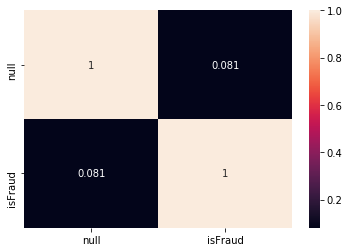

In [37]:
a = pd.DataFrame()

a['null'] = train['null']
a['isFraud'] = train['isFraud']
c = ['null','isFraud']
corr = a[c].corr()
sns.heatmap(corr,annot=True)

In [0]:
best = SelectKBest(score_func=f_classif, k=100)
fit = best.fit(x, y)

np.set_printoptions(precision=3)
print(fit.scores_)

features = fit.transform(X)
print(features[0:100,:])

# NO need

In [0]:
train_col['id_33'].fillna('0x0',inplace=True)
test_col['id_33'].fillna('0x0',inplace=True)
train['id_33_1'] = train_col['id_33'].astype(str).str.split('x').map(lambda x: x[0])
train['id_33_2'] = train_col['id_33'].astype(str).str.split('x').map(lambda x: x[1])
test['id_33_1'] = test_col['id_33'].astype(str).str.split('x').map(lambda x: x[0])
test['id_33_2'] = test_col['id_33'].astype(str).str.split('x').map(lambda x: x[1])

for i in ['id_33_1','id_33_2']:
  train[i] = le.fit_transform(train[i])
  test[i] = le.fit_transform(test[i])


train_col['id_30'].fillna('other',inplace=True)
test_col['id_30'].fillna('other',inplace=True)

#Binning
device = {'other':'other',
          'Android 7.0':'Android',
          'Android':'Android',
          'Android 5.1.1':'Android',
          'Android 7.1.1':'Android',
          'Android 6.0':'Android',
          'Android 8.0.0':'Android',
          'Android 6.0.1':'Android',
          'Android 5.0.2':'Android',
          'Android 4.4.2':'Android',
          'Android 5.0':'Android',
          'Android 7.1.2':'Android',
          'Android 8.1.0':'Android',
          'iOS 11.1.2':'iOS',
          'iOS 11.0.3':'iOS',
          'iOS 11.1.0':'iOS',
          'iOS 10.3.3':'iOS',
          'iOS 9.3.5':'iOS',
          'iOS 10.3.1':'iOS',
          'iOS 11.1.1':'iOS',
          'iOS 10.3.2':'iOS',
          'iOS 11.0.2':'iOS',
          'iOS 10.2.0':'iOS',
          'iOS 10.2.1':'iOS',
          'iOS 11.0.0':'iOS',
          'iOS 11.0.1':'iOS',
          'iOS 10.0.2':'iOS',
          'iOS 11.2.0':'iOS',
          'iOS 10.1.1':'iOS',
          'iOS 11.2.1':'iOS',
          'iOS 11.2.5':'iOS',
          'iOS 11.2.2':'iOS',
          'iOS 11.3.0':'iOS',
          'iOS 11.2.6':'iOS',
          'iOS 11.4.0':'iOS',
          'iOS 11.3.1':'iOS',
          'iOS 11.4.1':'iOS',
          'iOS':'iOS',
          'Mac OS X 10_11_6':'Mac',
          'Mac OS X 10_7_5':'Mac',
          'Mac OS X 10_12_6':'Mac',
          'Mac OS X 10_13_1':'Mac',
          'Mac OS X 10_9_5':'Mac',
          'Mac':'Mac',
          'Mac OS X 10.12':'Mac',
          'Mac OS X 10_10_5':'Mac',
          'Mac OS X 10_11_5':'Mac',
          'Mac OS X 10.11':'Mac',
          'Mac OS X 10.10':'Mac',
          'Mac OS X 10_12_3':'Mac',
          'Mac OS X 10_12':'Mac',
          'Mac OS X 10.13':'Mac',
          'Mac OS X 10_12_5':'Mac',
          'Mac OS X 10_8_5':'Mac',
          'Mac OS X 10.6':'Mac',
          'Mac OS X 10_6_8':'Mac',
          'Mac OS X 10_11_4':'Mac',
          'Mac OS X 10_12_1':'Mac',
          'Mac OS X 10_11_3':'Mac',
          'Mac OS X 10_12_4':'Mac',
          'Mac OS X 10_13_2':'Mac',
          'Mac OS X 10_12_2':'Mac',
          'Mac OS X 10_13_3':'Mac',
          'Mac OS X 10_13_4':'Mac',
          'Mac OS X 10_13_5':'Mac',
          'Windows 10':'Windows',
          'Windows 7':'Windows',
          'Windows 8.1':'Windows',
          'Windows Vista':'Windows',
          'Windows XP':'Windows',
          'Windows':'Windows',
          'Linux':'Linux',
          'func':'func'}
train['id_30_device'] = train_col['id_30'].map(device)
test['id_30_device'] = test_col['id_30'].map(device)

train['diff_id_27_29'] = np.zeros(train.shape[0])
train.loc[train["id_27"]!=train["id_29"],"diff_id_27_29"] = 1

test['diff_id_27_29'] = np.zeros(test.shape[0])
test.loc[test["id_27"]!=test["id_29"],"diff_id_27_29"] = 1



In [0]:
train_col['DeviceInfo'] = train_col['DeviceInfo'].fillna('unknown_device').str.lower()
train['DeviceInfo_device'] = train_col['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
train['DeviceInfo_version'] = train_col['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
train_col['id_30'] = train_col['id_30'].fillna('unknown_device').str.lower()
train['id_30_device'] = train_col['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
train['id_30_version'] = train_col['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
train_col['id_31'] = train_col['id_31'].fillna('unknown_device').str.lower()
train['id_31_device'] = train_col['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))


le.fit(list(train['id_30_device'].astype(str).values))
train['id_30_device'] = le.transform(list(train['id_30_device'].astype(str).values))

le.fit(list(train['id_30_version'].astype(str).values))
train['id_30_version'] = le.transform(list(train['id_30_version'].astype(str).values))

le.fit(list(train['id_31_device'].astype(str).values))
train['id_31_device'] = le.transform(list(train['id_31_device'].astype(str).values))

In [0]:
test_col['DeviceInfo'] = test_col['DeviceInfo'].fillna('unknown_device').str.lower()
test['DeviceInfo_device'] = test_col['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
test['DeviceInfo_version'] = test_col['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
test_col['id_30'] = test_col['id_30'].fillna('unknown_device').str.lower()
test['id_30_device'] = test_col['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
test['id_30_version'] = test_col['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
test_col['id_31'] = test_col['id_31'].fillna('unknown_device').str.lower()
test['id_31_device'] = test_col['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

le.fit(list(test['id_30_device'].astype(str).values))
test['id_30_device'] = le.transform(list(test['id_30_device'].astype(str).values))

le.fit(list(test['id_30_version'].astype(str).values))
test['id_30_version'] = le.transform(list(test['id_30_version'].astype(str).values))

le.fit(list(test['id_31_device'].astype(str).values))
test['id_31_device'] = le.transform(list(test['id_31_device'].astype(str).values))

In [0]:
for feature in tqdm_notebook(['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']):

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

In [0]:
print(train.shape)
print(test.shape)